<a href="https://colab.research.google.com/github/Ishan1923/Skin-Cancer-Detection-using-DL-techniques/blob/main/SkinCancerDetectionUsingVGG16Arch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nodoubttome_skin_cancer9_classesisic_path = kagglehub.dataset_download('nodoubttome/skin-cancer9-classesisic')

print('Data source import complete.')


Data source import complete.


In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import glob
from keras import layers
from tensorflow import data as tf_data

In [43]:
# !pip install tensorflow-gpu
!nvidia-smi

Fri Jun 27 08:02:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             31W /   70W |   14060MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [44]:
print("GPU available: ", tf.config.list_physical_devices('GPU'))

GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [45]:
import kagglehub

# Download the dataset
dataset_path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/skin-cancer9-classesisic


In [46]:
print("current directory contents: \n", os.listdir(dataset_path))

current directory contents: 
 ['Skin cancer ISIC The International Skin Imaging Collaboration']


In [47]:
ISIC_folder = os.path.join(dataset_path, os.listdir(dataset_path)[0])
print(ISIC_folder)

/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration


In [48]:
print(os.listdir(ISIC_folder))

['Test', 'Train']


In [49]:
train_image_folder = os.path.join(ISIC_folder, os.listdir(ISIC_folder)[0])
print(train_image_folder)

/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [50]:
os.listdir(train_image_folder)

['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [51]:
test_image_folder = os.path.join(ISIC_folder, os.listdir(ISIC_folder)[0])
print(test_image_folder)

/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [52]:
os.listdir(train_image_folder)

['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [53]:
os.listdir(test_image_folder)

['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']

In [54]:
train_images_address = []
train_images_labels = []
test_images_address = []
test_images_labels = []

count = 0
for folder in os.listdir(train_image_folder):
    folder_path = os.path.join(train_image_folder, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        train_images_address.append(file_path)
        train_images_labels.append(count)
    count = count + 1

count = 0
for folder in os.listdir(test_image_folder):
    folder_path = os.path.join(test_image_folder, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        test_images_address.append(file_path)
        test_images_labels.append(count)
    count = count + 1

print("total classes in training folder: ", len(train_images_address))
print("total classes in test folder: ", len(test_images_address))
print("total training images: ",len(train_images_labels))
print("total test images", len(test_images_labels))



total classes in training folder:  118
total classes in test folder:  118
total training images:  118
total test images 118


In [55]:
class TFPreprocessingPipiline:
  def __init__(self, img_size = (224,224), batch_size = 32):
    self.img_size = img_size
    self.batch_size = batch_size

  def preprocess_image(self, image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels = 3)
    image = tf.reshape(image, [tf.shape(image)[0], tf.shape(image)[1], 3])
    image = tf.image.resize(image, self.img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

  def preprocess_with_augmentation(self, image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)
    image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)


    k = tf.random.uniform([], 0, 4, tf.int32)
    image = tf.image.rot90(image, k)

    image = tf.clip_by_value(image, 0, 1)

    return image, label

  def create_dataset_from_directory(self, data_dir, validation_split = 0.2, subset = 'training', augment = True):
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = validation_split,
        subset = subset,
        seed = 42,
        image_size = self.img_size,
        batch_size = self.batch_size,
        label_mode = 'categorical'
    )

    if augment and subset == 'training':
      dataset = dataset.map(self.apply_augmentation_to_batch, num_paraller_calls = tf.data.AUTOTUNE)

    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

  def apply_augmentation_to_batch(self, images, labels):
    augmented_images = tf.map_fn(
        lambda img: self.augment_single_image(img),
        images,
        parallel_iterations = 10,
        dtype = tf.float32
    )
    return augmented_images, labels

  def augment_single_images(self, images):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

  def create_dataset_from_paths_and_labels(self, image_paths, labels, augment = True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    dataset = dataset.map(self.preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)

    if augment :
      dataset = dataset.map(self.preprocess_with_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
    else:
      dataset = dataset.map(self.preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(self.batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

  def create_dataset_for_prediction(self, image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(
        lambda path : self.preprocess_image_only(path),
        num_parallel_calls = tf.data.AUTOTUNE
        )

    dataset = dataset.batch(self.batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

  def preprocess_image_only(self, image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels = 3)
    image = tf.reshape(image, [tf.shape(image)[0], tf.shape(image)[1], 3])
    image = tf.image.resize(image, self.img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

  def visualize_batch(self, dataset, num_images = 9):
    import matplotlib.pyplot as plt

    for images in dataset.take(1):
      fig, ax = plt.subplots(3,3, figsize = (10,10))
      ax = ax.ravel()

      for i in range(min(num_images, len(images))):
        img = images[i].numpy()
        ax[i].imshow(img)
        ax[i].axis('off')

      plt.tight_layout()
      plt.show()
      break



In [56]:
# preprocessing_pipeline = PreprocessingTrainingData()
# training_dataset = preprocessing_pipeline.create_dataset(train_images_address, train_images_labels)
# test_dataset = preprocessing_pipeline.create_dataset_for_prediction(test_images_address)

In [57]:
# training_dataset.take(1)

In [58]:
# preprocessing_pipeline.visualize_batch(training_dataset)

In [59]:
print(len(train_images_address), len(train_images_labels))

118 118


In [60]:
print(len(test_images_address), len(test_images_labels))

118 118


In [61]:
pipeline = TFPreprocessingPipiline(img_size=(224, 224), batch_size = 32)

train_dataset = pipeline.create_dataset_from_paths_and_labels(train_images_address, train_images_labels)

print(f"dataset: {train_dataset}")

test_dataset = pipeline.create_dataset_from_paths_and_labels(test_images_address, test_images_labels)
t_dataset = pipeline.create_dataset_for_prediction(test_images_address)
print(f"dataset: {test_dataset}")

train_dataset.take(1)

dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

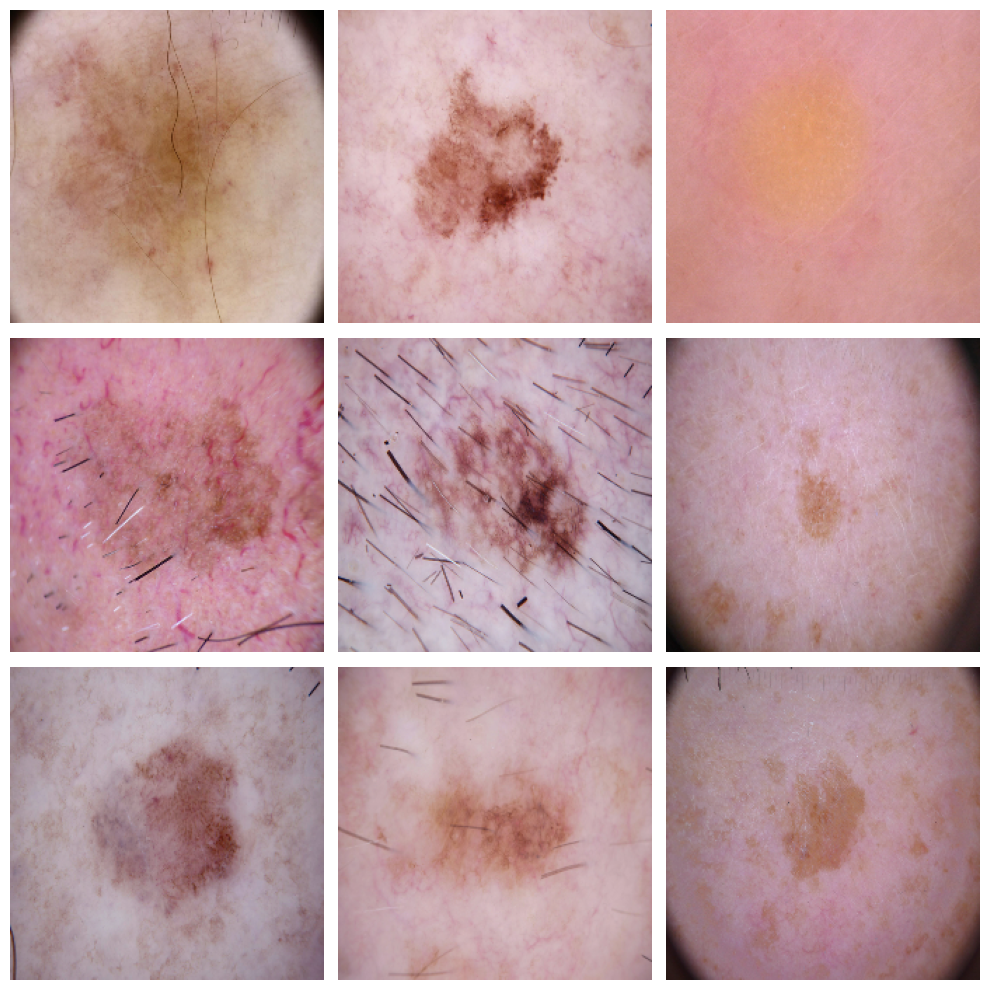

In [62]:
pipeline.visualize_batch(t_dataset)

### Building the VGG16 Architecture Model

In [63]:
def model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = keras.layers.Rescaling(scale=1.0 / 255.0)(inputs)

    # First conv block
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)

    # Second conv block
    x = keras.layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)

    # Third conv block
    x = keras.layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)

    # Fourth conv block
    x = keras.layers.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        padding="same",
        strides=1,
        activation="relu"
    )(x)
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    )(x)

    # Flatten before dense layers
    x = keras.layers.Flatten()(x)

    # Fully connected layers
    x = keras.layers.Dense(
        units=4096,
        activation="relu"
    )(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Dense(
        units=4096,
        activation="relu"
    )(x)
    x = keras.layers.Dropout(0.5)(x)

    # Output layer
    outputs = keras.layers.Dense(
        units=num_classes,
        activation="softmax"
    )(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [64]:
print(len(os.listdir(train_image_folder)) )

9


In [65]:
model = model(input_shape=(224, 224, 3), num_classes=len(os.listdir(train_image_folder)))

In [66]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [67]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │   411,045,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │        36,873 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,499,337 (1.62 GB)

 Trainable params: 435,499,337 (1.62 GB)

 Non-trainable params: 0 (0.00 B)

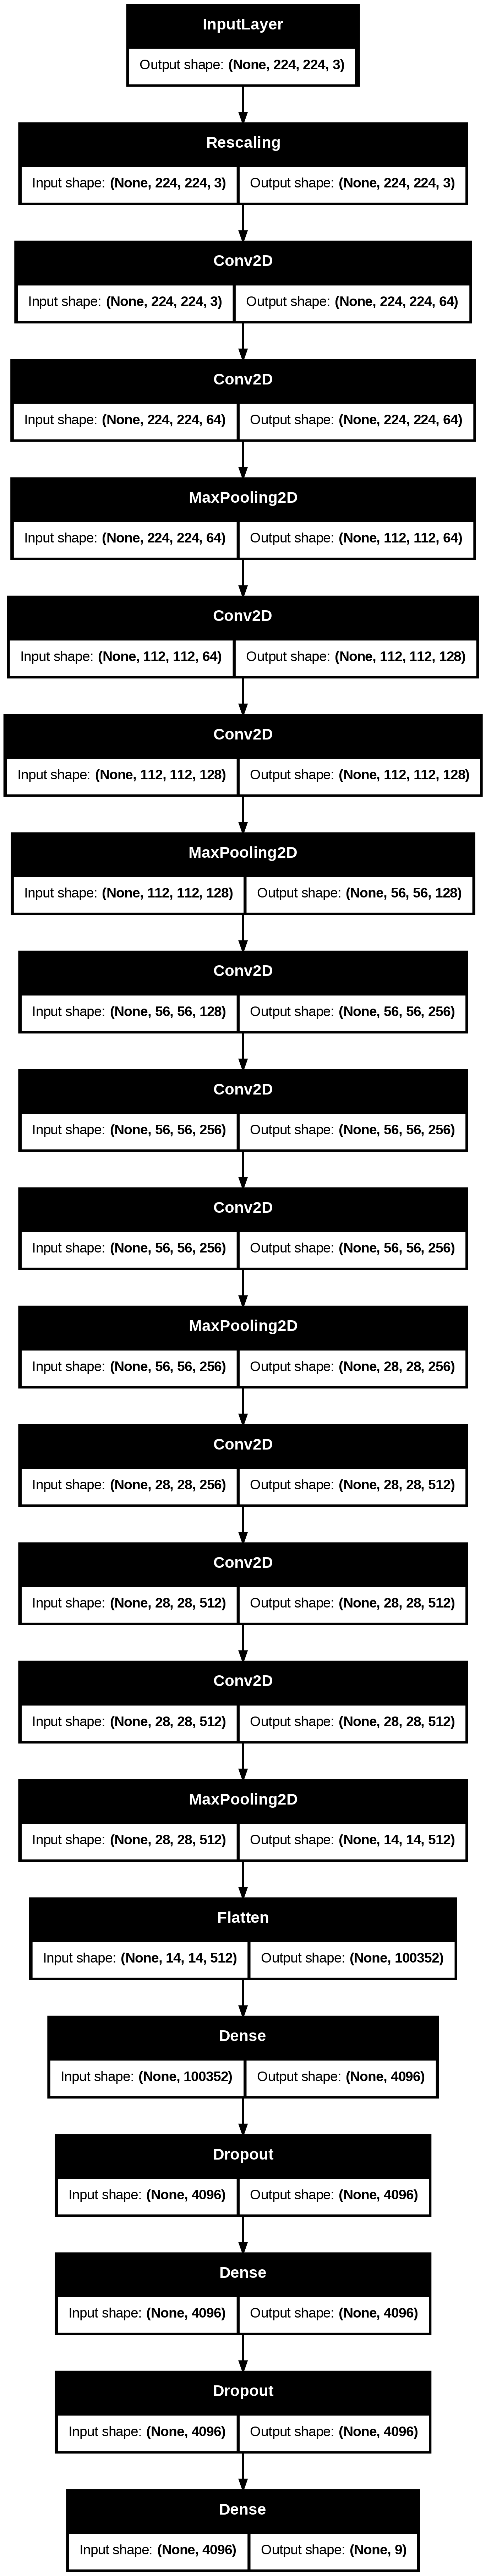

In [68]:
keras.utils.plot_model(model, show_shapes = True)

In [69]:
callbacks = [
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3
        )
    ]

In [70]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [71]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [72]:
# history = model.fit(
#     train_dataset,
#     batch_size=1,
#     epochs=1,
#     validation_data=test_dataset,
#     callbacks=callbacks,
#     verbose=1
# )

In [73]:
# test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
# print(f"Test Accuracy: {test_accuracy:.4f}")

In [74]:
from keras.applications import VGG16 as vgg16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model as models

base_model = vgg16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=len(os.listdir(train_image_folder)),
    classifier_activation="softmax",
    name="vgg16",
)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.5)(x)

num_classes = len(os.listdir(train_image_folder))
output = layers.Dense(num_classes, activation="softmax")(x)

model = models(inputs = base_model.input, outputs = output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,848,329 (56.64 MB)

 Trainable params: 133,641 (522.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

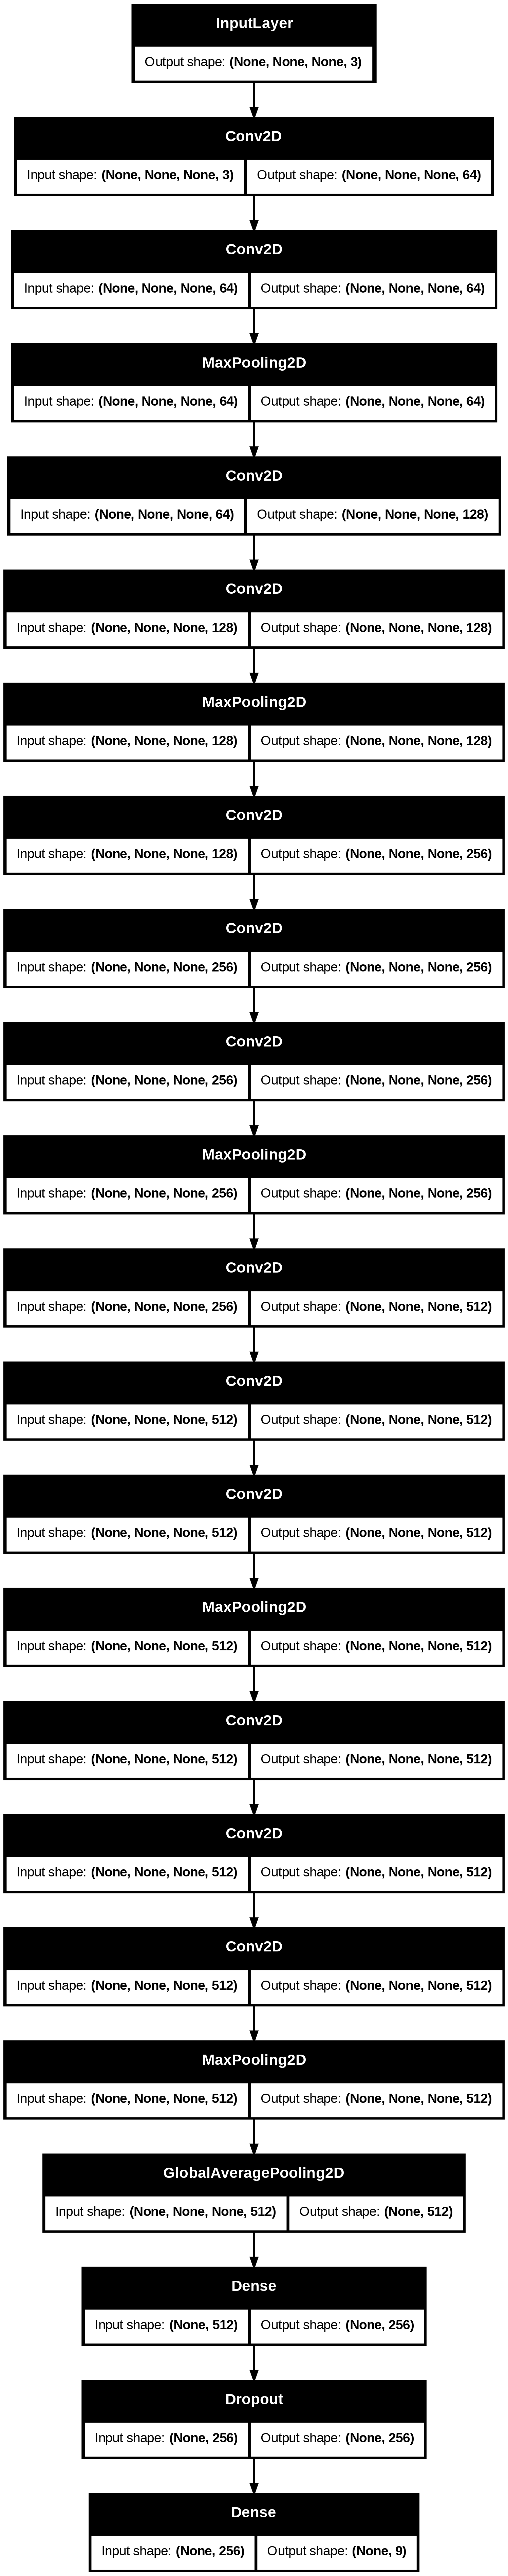

In [75]:
keras.utils.plot_model(model, show_shapes = True)

In [76]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
callbacks = [
        keras.callbacks.EarlyStopping(
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            patience=3
        )
    ]

In [77]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [78]:
model.fit(
    x=train_dataset,
    batch_size=32,
    epochs=50,
    verbose=1,
    callbacks=callbacks,
    validation_data = test_dataset,
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.1199 - loss: 2.5387 - val_accuracy: 0.1949 - val_loss: 2.1064 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.2199 - loss: 2.1777 - val_accuracy: 0.2203 - val_loss: 2.0283 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - accuracy: 0.0935 - loss: 2.1574 - val_accuracy: 0.2712 - val_loss: 1.9889 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 0.1683 - loss: 2.0893 - val_accuracy: 0.3644 - val_loss: 1.9468 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.2009 - loss: 2.0388 - val_accuracy: 0.4068 - val_loss: 1.9122 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.2363 - loss: 1.9851 - val_accuracy: 0.4576 - val_loss: 1.8822 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.2822 - loss: 1.9552 - val_accuracy: 0.

In [80]:
from google.colab import drive
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/models/vgg"
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, "my_model.keras"))
model.save("/content/drive/MyDrive/my_model.keras")

Mounted at /content/drive
